In [3]:
from pdf2image import convert_from_path
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import PIL
import math
import cv2

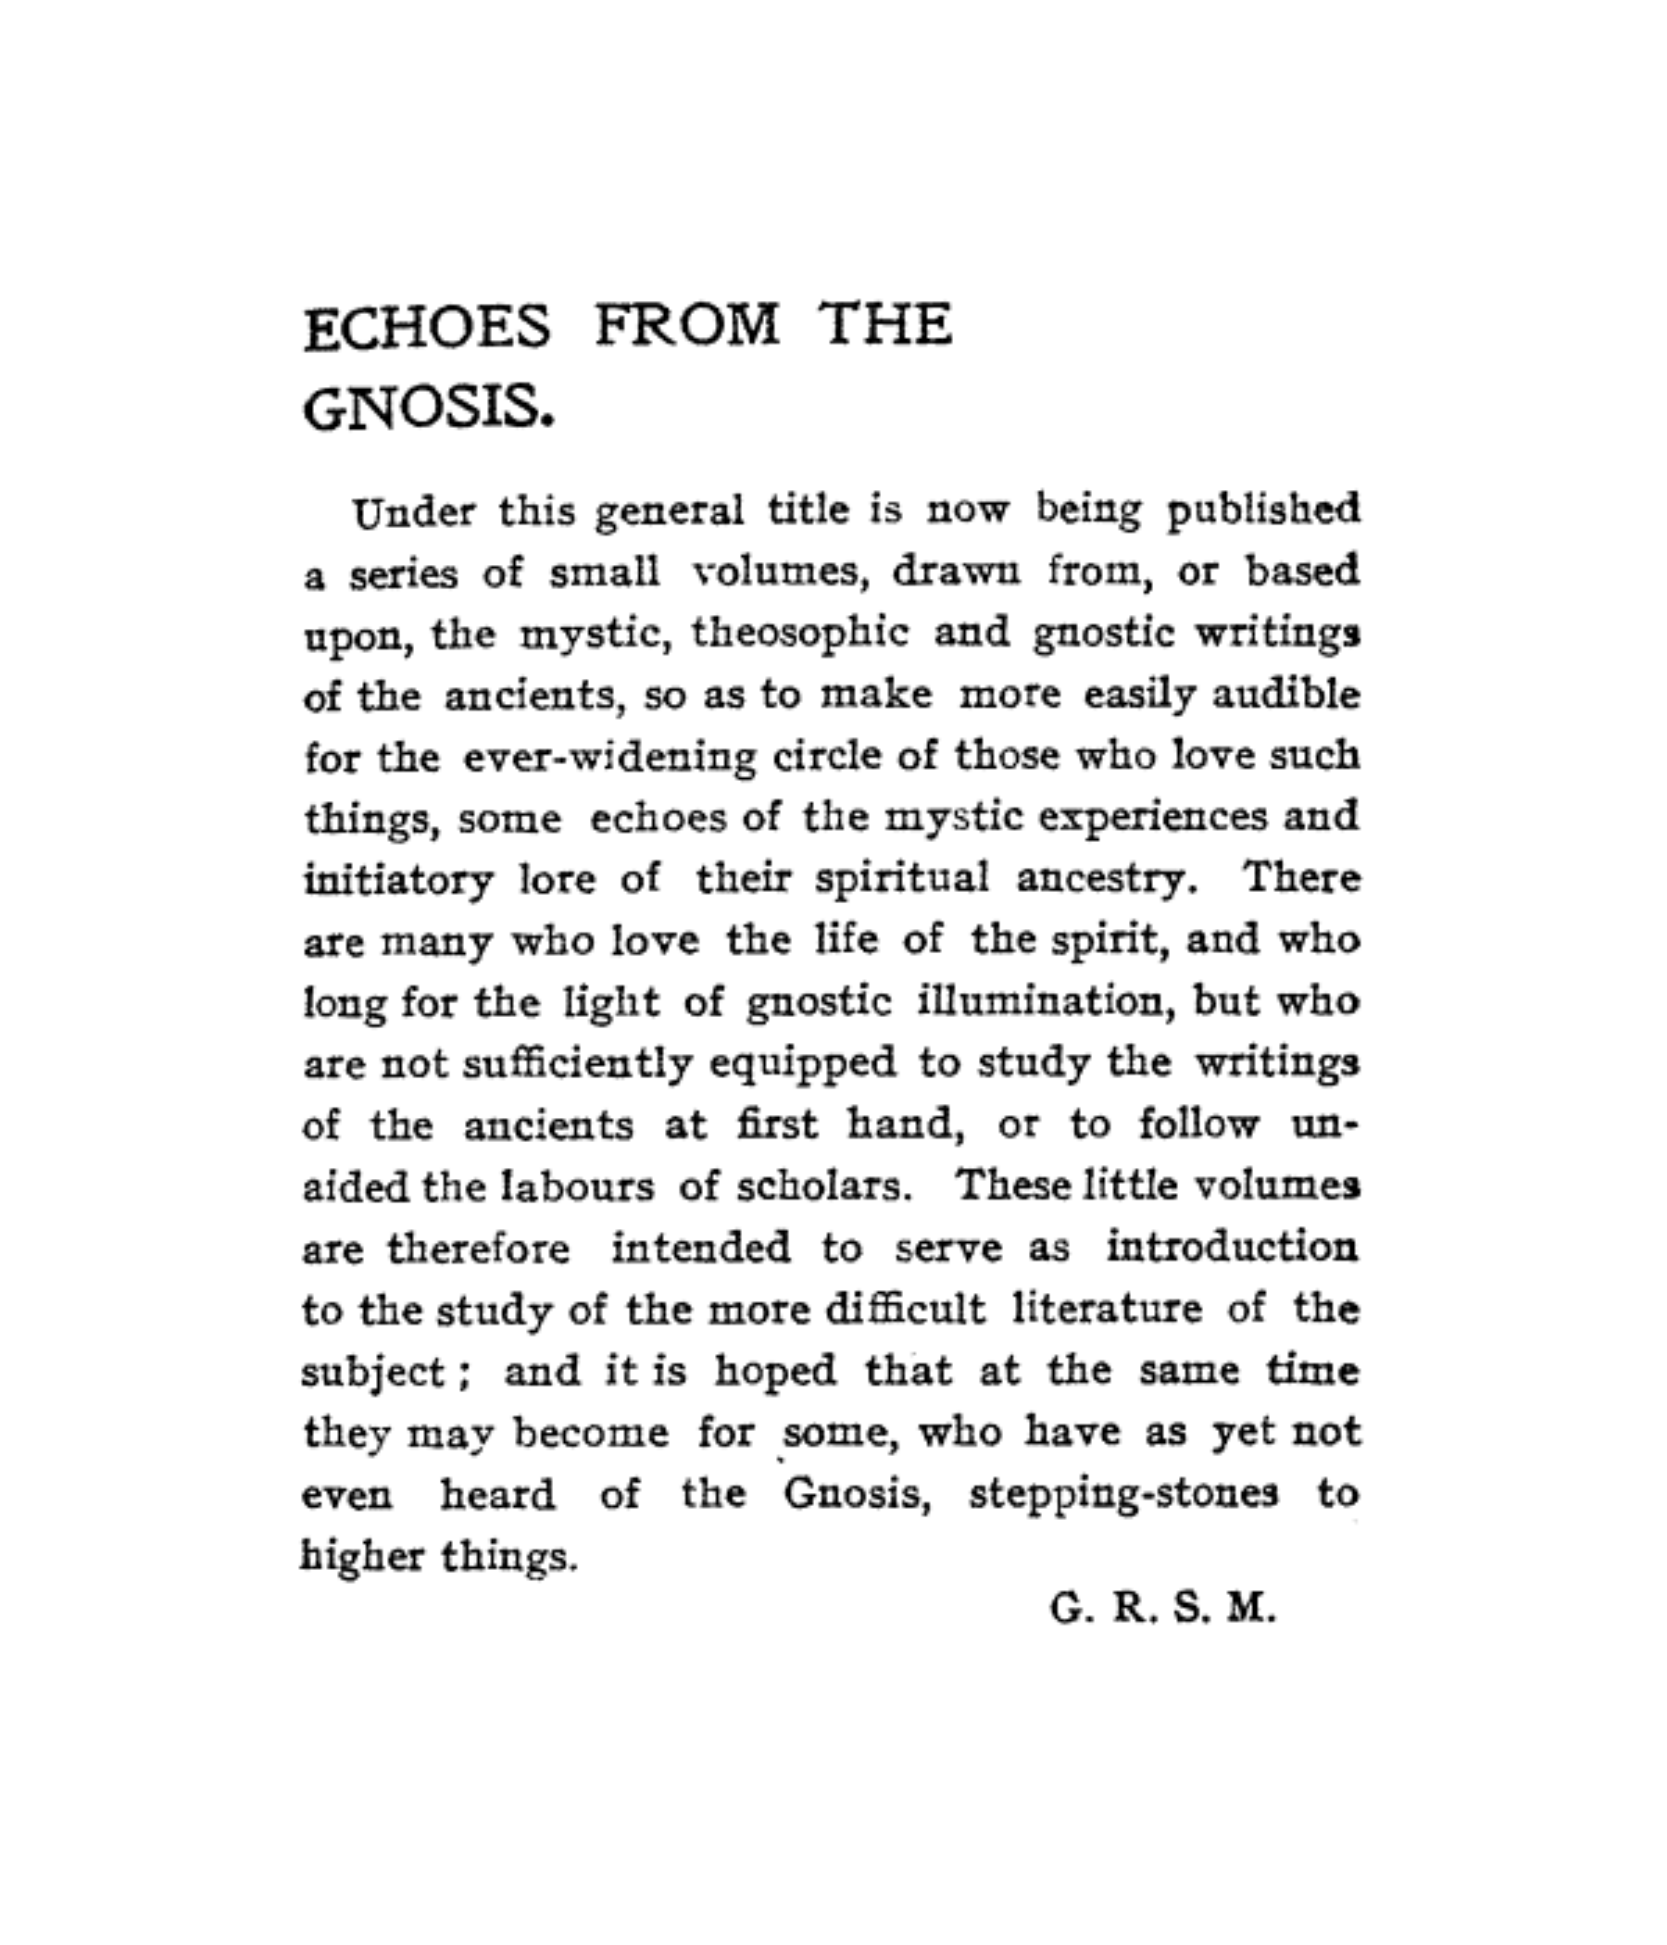

In [4]:
pdf_images = convert_from_path("./Chaldean-oracles.pdf")
pdf_images[1]

In [5]:
def PIL_to_CV(image):
    opencvImage = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    return opencvImage

def CV_to_PIL(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return PIL.Image.fromarray(img)

In [6]:
IMG_W=32 * 40
IMG_H=32 * 45

def preprocess_image(image):

    clahe = cv2.createCLAHE().apply(image)

    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpen = cv2.filter2D(clahe, -1, sharpen_kernel)

    image = cv2.dilate(cv2.threshold(clahe, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1],np.ones((0, 0), np.uint8))

    orig = image.copy()
    (H, W) = image.shape[:2]
    (newW, newH) = (IMG_W, IMG_H)

    rW = W / float(newW)
    rH = H / float(newH)
    image = cv2.resize(image, (newW, newH))

    # (H, W) = image.shape[:2]
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

In [7]:
result = preprocess_image(PIL_to_CV(pdf_images[6]))
original = PIL_to_CV(pdf_images[6])


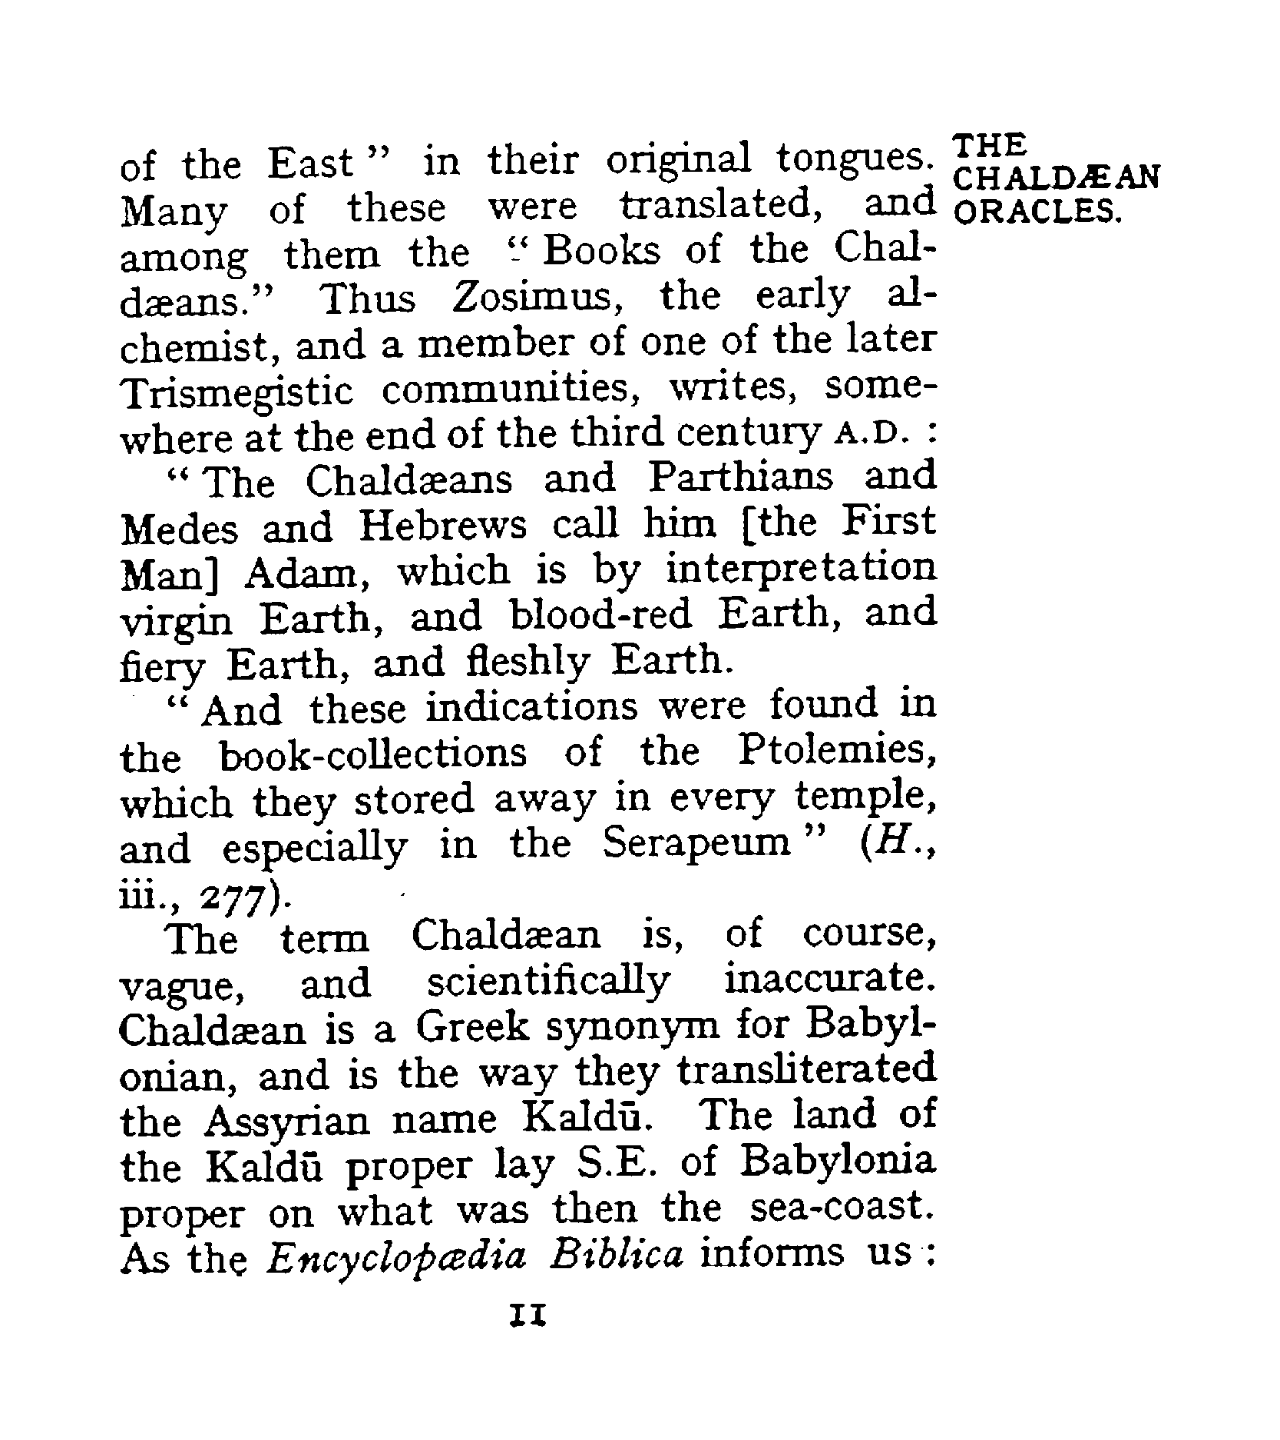

In [8]:
CV_to_PIL(result)

In [9]:
net = cv2.dnn.readNet("./frozen_east_text_detection.pb")

In [10]:
blob = cv2.dnn.blobFromImage(result, 1.0, (IMG_H, IMG_W),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)

In [11]:
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")


In [12]:
net.setInput(blob)
output = net.forward(outputLayers)
scores = output[0]
geometry = output[1]

In [13]:
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

for y in range(0, numRows):
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.4:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

In [14]:
boxes = non_max_suppression(np.array(rects), probs=confidences)


In [15]:
result.shape
# original.shape

(1440, 1280, 3)

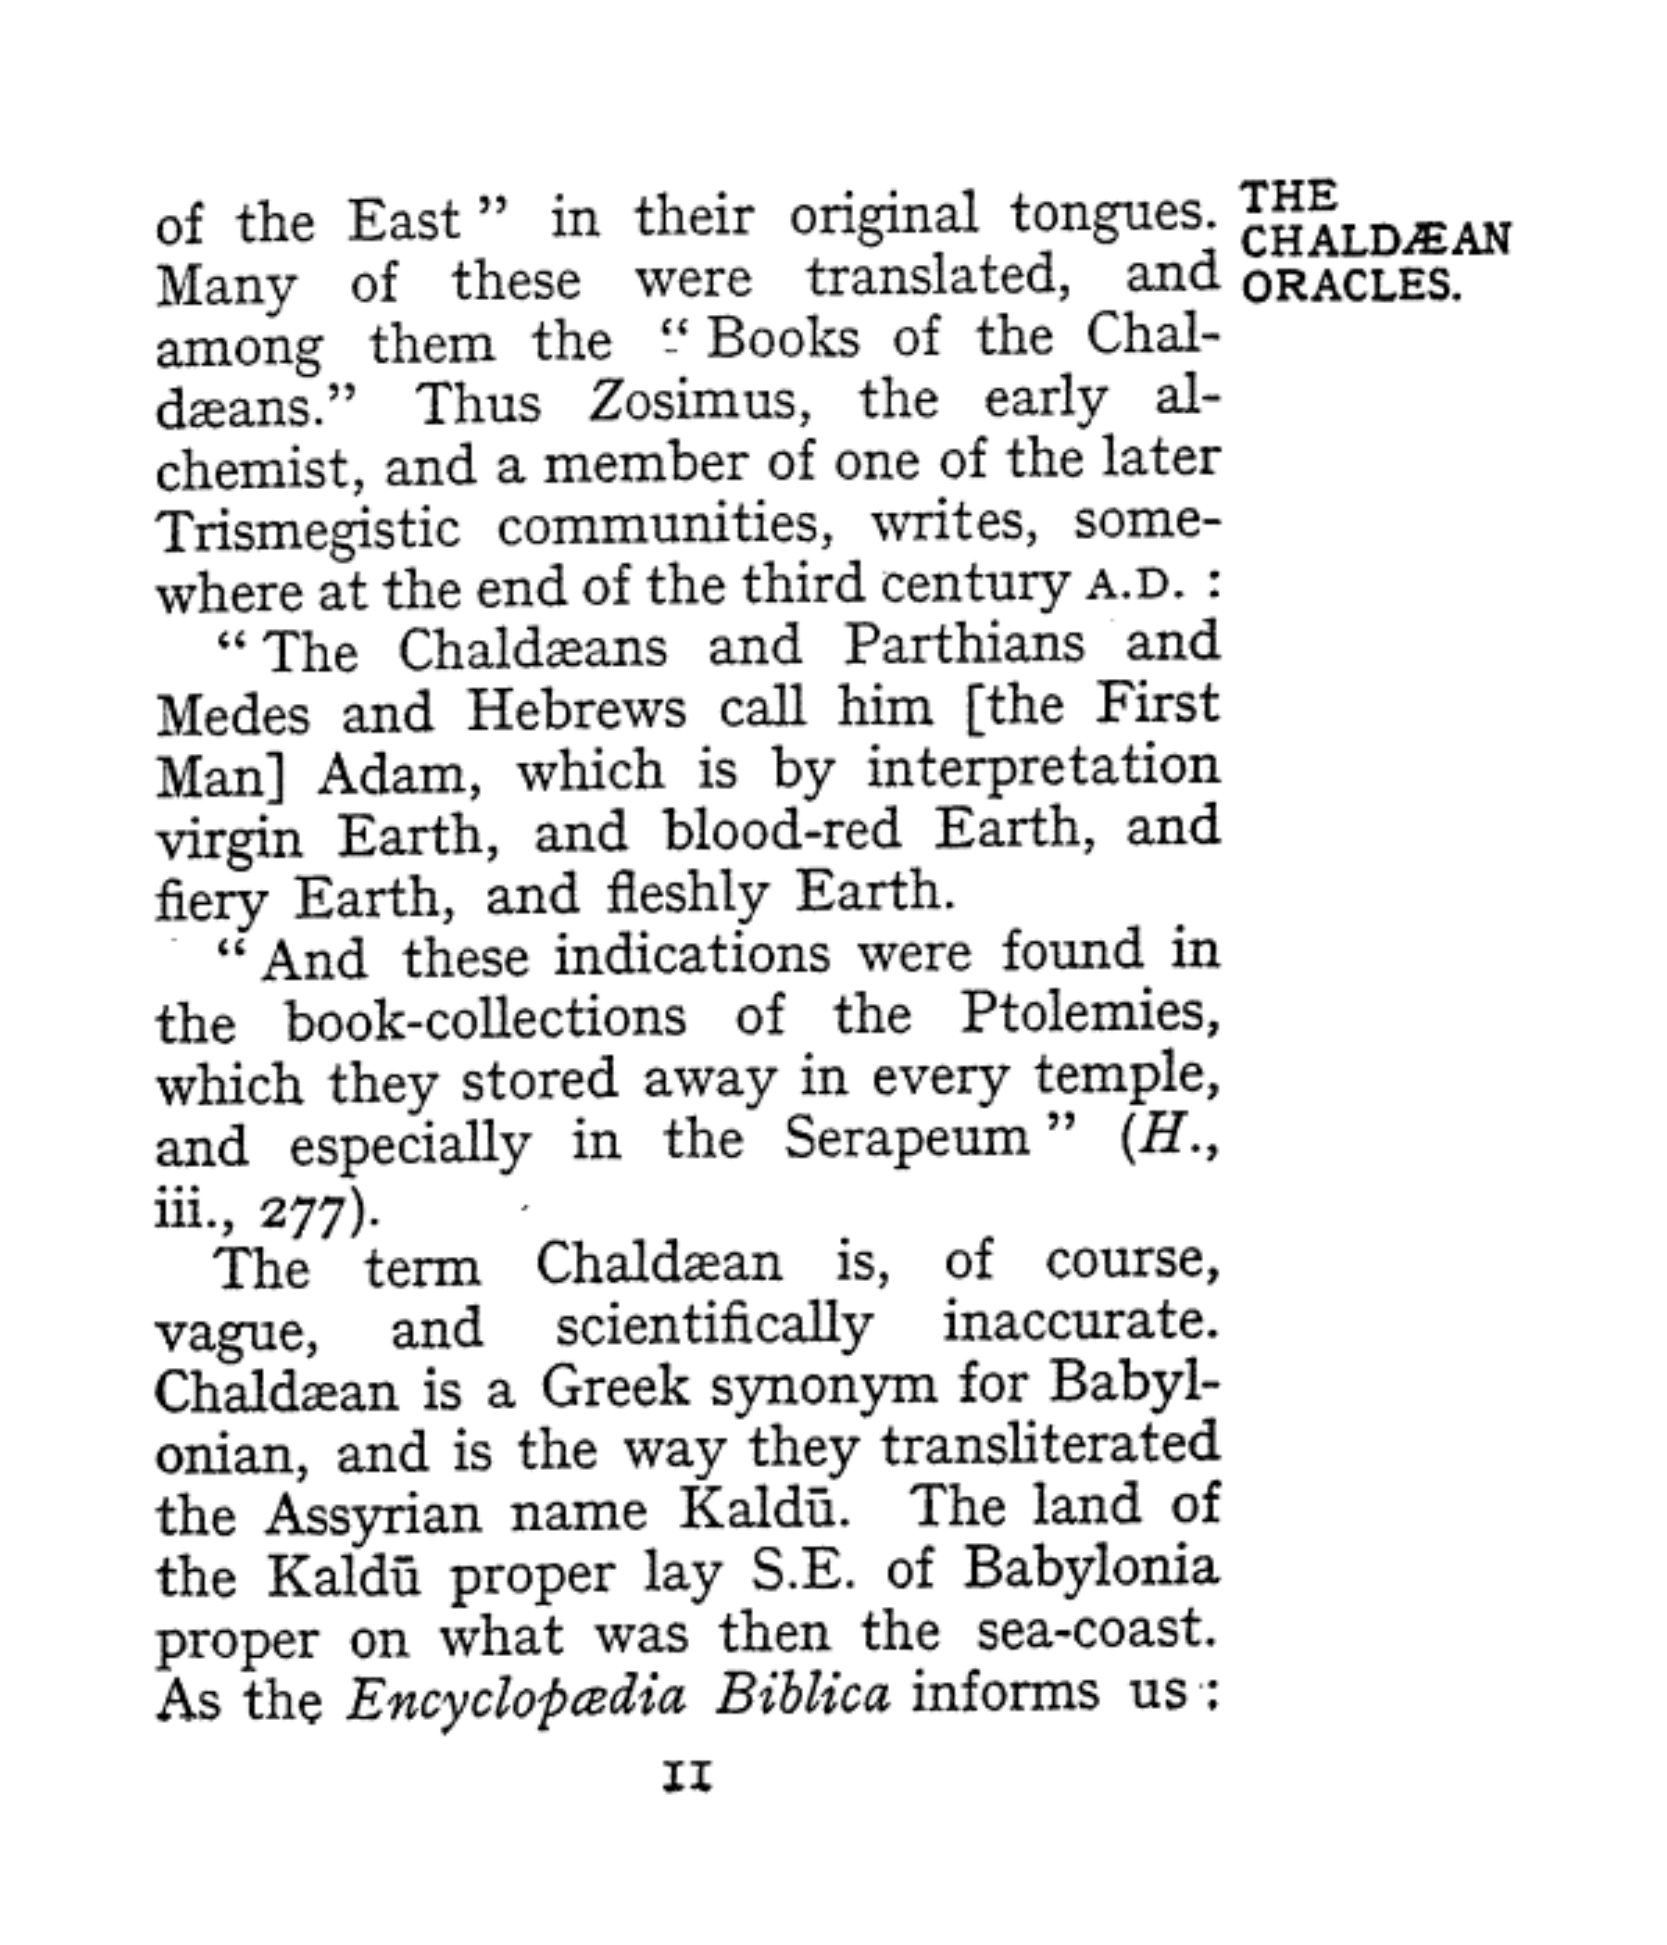

In [16]:

east_crops = []
tolerance = 10
original = PIL_to_CV(pdf_images[6])
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    (H, W) = original.shape[:2]
    (newW, newH) = result.shape[:2]
    rW = W / float(newW)
    rH = H / float(newH)
    startX = int(startX * rW) - tolerance
    startY = int(startY * rH) - tolerance
    endX = int(endX * rW) + tolerance
    endY = int(endY * rH) + tolerance

    # draw the bounding box on the image
    # cv2.rectangle(original, (startX, startY), (endX, endY), (0, 255, 0), 2)

    east_crops.insert(0, original[startY :endY , startX : endX])

CV_to_PIL(original)



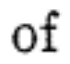

In [17]:
CV_to_PIL(east_crops[20])

In [18]:
def captch_ex(img2gray):
    cropped_images = []
    img2gray = cv2.cvtColor(img2gray, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 180, 255, cv2.THRESH_BINARY)
    image_final = cv2.bitwise_and(img2gray, img2gray, mask=mask)
    ret, new_img = cv2.threshold(image_final, 180, 255, cv2.THRESH_BINARY_INV)  # for black text , cv.THRESH_BINARY_INV
    '''
            line  8 to 12  : Remove noisy portion 
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,
                                                         1))  # to manipulate the orientation of dilution , large x means horizonatally dilating  more, large y means vertically dilating more
    dilated = cv2.dilate(new_img, kernel, iterations=50)  # dilate , more the iteration more the dilation
    # eroded = cv2.erode(dilated, (5,5), iterations=5)


    contours, hierarchy = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)  # findContours returns 3 variables for getting contours

    for contour in contours:
        # get rectangle bounding contour
        [x, y, w, h] = cv2.boundingRect(contour)

        # Don't plot small false positives that aren't text
        if w < 35 and h < 35:
            continue

        # draw rectangle around contour on original image
        cv2.rectangle(img2gray, (x, y), (x + w, y + h), (0, 255, 0), 2)

        cropped_images.insert(0, img2gray[y :y +  h , x : x + w])
        '''
        #you can crop image and send to OCR  , false detected will return no text :)

        s = file_name + '/crop_' + str(index) + '.jpg' 
        cv2.imwrite(s , cropped)
        index = index + 1

        '''
    return img2gray, cropped_images

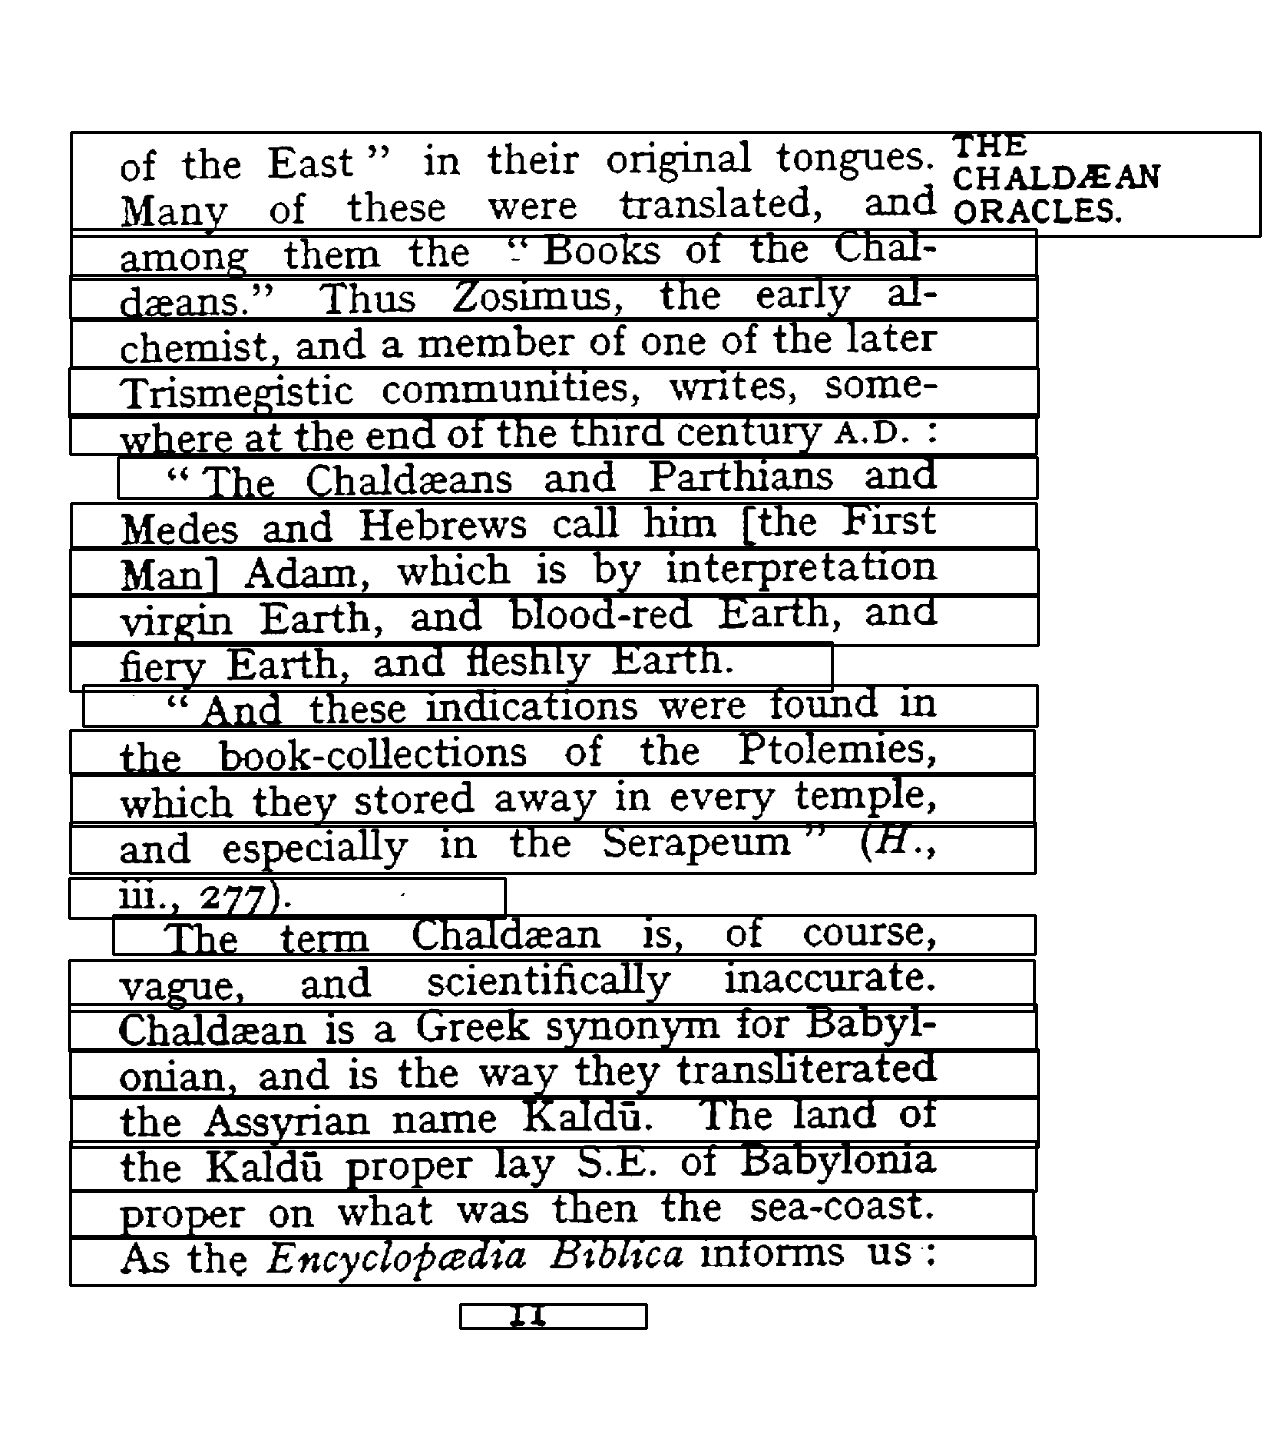

In [19]:
image, t = captch_ex(preprocess_image(PIL_to_CV(pdf_images[6])))
CV_to_PIL(image)

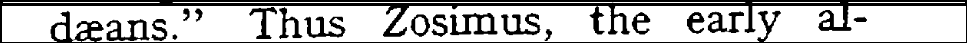

In [20]:
CV_to_PIL(t[2])

In [21]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
text = []
for image in t:
    pixel_values = processor(images=CV_to_PIL(image), return_tensors="pt").pixel_values

    generated_ids = model.generate(pixel_values)
    text.append(processor.batch_decode(generated_ids, skip_special_tokens=True)[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/opt/homebrew/lib/python3.10/site-packages/transformers/generation_utils.py:1227: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask and the pad token id were not set. As a conseq

In [24]:
text

['OF THE BEST "IN THEIR ORIGINAL TONGUES, CHALDRAN',
 'AMONG THEM THE "BOOKS OF THE CHAL-',
 'DREAMS." THUS ZOSIMUS, THE EARLY AL-',
 'CHEMIST, AND A MEMBER OF ONE OF THE LATER',
 'TRISMEGISTIC COMMUNITIES, WRITES, SOME-',
 'WHERE AT THE END OF THE THIRD CENTURY A.D.:',
 '"THE CHALDEANS AND PARTHIANS AND',
 'MEDES AND HEBREWS CALL HIM [THE FIRST',
 'MAN] ADAM, WHICH IS BY INTERPETATION',
 'VIRGIN EARTH, AND BLOOD-RED EARTH, AND',
 'FIERY EARTH, AND HESHLY EARTH.',
 '"AND THESE INDICATIONS WERE FOUND IN',
 'THE BOOK-COLLECTIONS OF THE PTOLEMIES,',
 'WHICH THEY STORED AWAY IN EVERY TEMPLE,',
 'AND ESPECIALLY IN THE SERAPEUM " (H.,',
 'III., 277).',
 'THE TERM CHALDIAN IS, OF COURSE,',
 'VAGUE, AND SCIENTIFICALLY INACCURATE.',
 'CHALDARAN IS A GREEK SYNONYM FOR BABYL-',
 'ONIAN, AND IS THE WAY THEY TRANSLITERATED',
 'THE ASSYRIAN NAME KALDU. THE LAND OF',
 'THE KALDU PROPER LAY S.E. OF BABYLONIA',
 'PROPER ON WHAT WAS THEN THE SEA-COAST.',
 'AS THE ENEYCLOPEDIA BibleA INFORMS US:',
 'II']

In [25]:
# page_number = 1
# text = []
# for page in pdf_images[72:]:
#     _, crops = captch_ex(preprocess_image(PIL_to_CV(page)))
#     for image in crops:
#         pixel_values = processor(images=CV_to_PIL(image), return_tensors="pt").pixel_values

#         generated_ids = model.generate(pixel_values)
#         text.append(processor.batch_decode(generated_ids, skip_special_tokens=True)[0])
#     with open(f'./pages/page_{page_number}.txt', "w") as text_file:
#         text_file.write("\n".join(text))
#     page_number = page_number + 1
    